In [12]:
# Strategies imports
from strategies.donchian_breakout import DonchianBreakout
from strategies.RSI_MOM_2 import RSI_Trading_Strategy
from strategies.PA_test import PA_Test

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:01


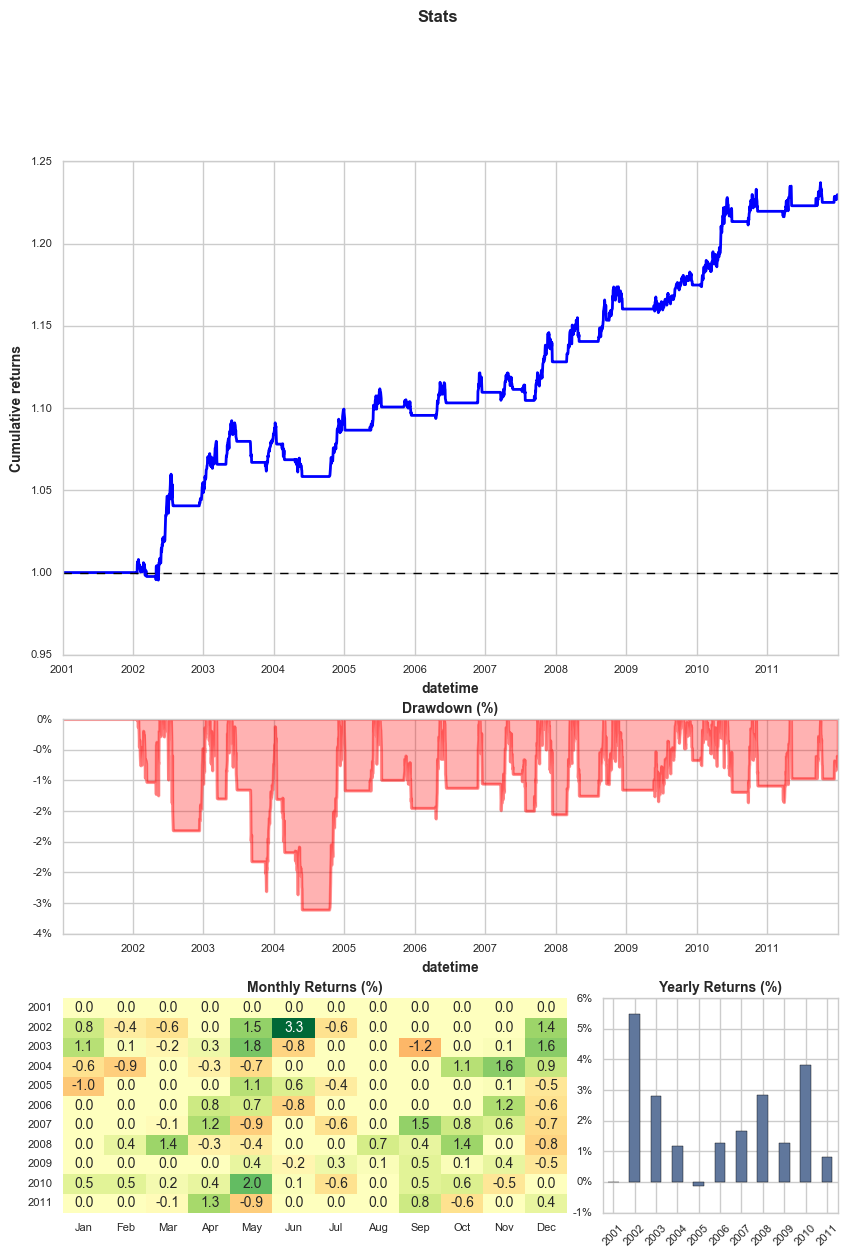

,Base Stats
#Trades,24.000000
CAGR(%),1.893496
Avg trade(R),0.934276
Daily Sharpe,0.843015


In [13]:
import queue
import matplotlib.pyplot as plt
from datetime import datetime

from broker.data_handlers.arctic_data_handler import ArcticDatabaseDataHandler
from broker.data_handlers.CSV_data_handler import CSVDataHandler
from broker.execution_handler import SimulatedExecution
from portfolio import Portfolio
from Engine.backtest_engine import BacktestEngine
from broker.account import SimulatedAccount
from trade_store.mongo_data_store import MongoTradeStore
from strategy_manager import StrategyManager
%matplotlib inline


#PARAMETERS
symbol_list= ['EURUSD']
risk= 0.01
equity = 1000.0
leverage = 20
start_date= datetime(2001,1,1)
end_date= datetime(2011,12,31)


events_queue = queue.Queue()
account = SimulatedAccount(equity,leverage,'USD')

prices= CSVDataHandler(events_queue=events_queue, symbol_list=symbol_list,account=account,
                             timeframe='D1', start_date=start_date,end_date=end_date)

strategy_3 = DonchianBreakout(prices,events_queue, entry_lookback=100, exit_lookback=50, atr_stop=3.,TP_atr=5.,name='DC_100x50')
#strategy_5 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=15, rsi_trigger_offset=25,trailing_stop_atr=1.8, take_profit_atr=3)

manager = StrategyManager([strategy_3])

store = MongoTradeStore(db_name='TRADES')
store.clear_tables()

portfolio = Portfolio(events_queue=events_queue, prices=prices,account=account,strat_manager=manager,
                      risk_per_trade = risk,data_store=None)
portfolio.open_trades.clear()
portfolio.compound=False

execution = SimulatedExecution(events_queue,prices,spread=0.0003)
backtest = BacktestEngine(events_queue, prices, execution, portfolio, manager)

backtest.run()
backtest.stats.plot_results()
backtest.stats.output_base_stats()

# Backtest Analysis

In [14]:
backtest.stats.get_results()

,All Trades,Long only,Short only
#Trades,24,15,9
CAGR(%),1.8935,NaN,NaN
Avg trade(R),0.934276,1.20155,0.488819
Daily Sharpe,0.843015,NaN,NaN
Max Drawdown(%),3.11043,NaN,NaN
Avg Duration,62 days 22:00:00,67 days 03:12:00,55 days 21:20:00
Exposure %,38.2003,25.1751,13.0252
Win Rate %,75,0.866667,0.555556
Avg Win,1.50441,1.51085,1.48767
Avg Loss,-0.776136,-0.808923,-0.759743


In [15]:
daily_ret = backtest.stats.history.returns
daily_ret.to_csv('/Users/jejemoreau/Dropbox/Quant/Prog/pyTrading2/daily_returns.csv')



In [16]:
exposure= backtest.stats.exposure[symbol_list[0]]
exposure[exposure > 1]=1
exposure[exposure < -1]=-1

In [17]:
exposure.to_csv('/Users/jejemoreau/Dropbox/Quant/Prog/pyTrading2/rule_output.csv')

2001-01-03    0.0
2001-01-04    0.0
2001-01-05    0.0
2001-01-08    0.0
2001-01-09    0.0
2001-01-10    0.0
2001-01-11    0.0
2001-01-12    0.0
2001-01-15    0.0
2001-01-16    0.0
2001-01-17    0.0
2001-01-18    0.0
2001-01-19    0.0
2001-01-22    0.0
2001-01-23    0.0
2001-01-24    0.0
2001-01-25    0.0
2001-01-26    0.0
2001-01-29    0.0
2001-01-30    0.0
2001-01-31    0.0
2001-02-01    0.0
2001-02-02    0.0
2001-02-05    0.0
2001-02-06    0.0
2001-02-07    0.0
2001-02-08    0.0
2001-02-09    0.0
2001-02-12    0.0
2001-02-13    0.0
             ... 
2011-11-21    0.0
2011-11-22    0.0
2011-11-23    0.0
2011-11-24    0.0
2011-11-25    0.0
2011-11-28    0.0
2011-11-29    0.0
2011-11-30    0.0
2011-12-01    0.0
2011-12-02    0.0
2011-12-05    0.0
2011-12-06    0.0
2011-12-07    0.0
2011-12-08    0.0
2011-12-09    0.0
2011-12-12    0.0
2011-12-13   -1.0
2011-12-14   -1.0
2011-12-15   -1.0
2011-12-16   -1.0
2011-12-19   -1.0
2011-12-20   -1.0
2011-12-21   -1.0
2011-12-22   -1.0
2011-12-23

In [21]:
backtest.stats.exposure['EURUSD']

2001-01-03      0.0
2001-01-04      0.0
2001-01-05      0.0
2001-01-08      0.0
2001-01-09      0.0
2001-01-10      0.0
2001-01-11      0.0
2001-01-12      0.0
2001-01-15      0.0
2001-01-16      0.0
2001-01-17      0.0
2001-01-18      0.0
2001-01-19      0.0
2001-01-22      0.0
2001-01-23      0.0
2001-01-24      0.0
2001-01-25      0.0
2001-01-26      0.0
2001-01-29      0.0
2001-01-30      0.0
2001-01-31      0.0
2001-02-01      0.0
2001-02-02      0.0
2001-02-05      0.0
2001-02-06      0.0
2001-02-07      0.0
2001-02-08      0.0
2001-02-09      0.0
2001-02-12      0.0
2001-02-13      0.0
              ...  
2011-11-21      0.0
2011-11-22      0.0
2011-11-23      0.0
2011-11-24      0.0
2011-11-25      0.0
2011-11-28      0.0
2011-11-29      0.0
2011-11-30      0.0
2011-12-01      0.0
2011-12-02      0.0
2011-12-05      0.0
2011-12-06      0.0
2011-12-07      0.0
2011-12-08      0.0
2011-12-09      0.0
2011-12-12      0.0
2011-12-13   -202.0
2011-12-14   -202.0
2011-12-15   -202.0


In [22]:
trades = backtest.stats.trades
trades_per_years = trades.open_date.groupby(trades.open_date.dt.year).count()
ce = backtest.stats.cagr /trades_per_years.mean() *100
print('Cost efficiency %0.2f' %ce)
print('Avg trades_per_years',trades_per_years.mean())

Cost efficiency 0.79
Avg trades_per_years 2.4


In [23]:
print("R-squared %0.2f" %backtest.stats.r_squared)

R-squared 0.96


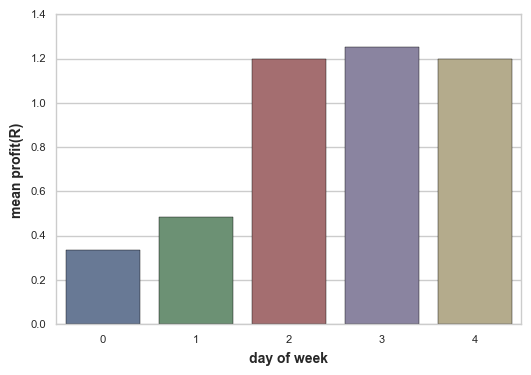

In [24]:
import seaborn as sns
import pandas as pd

df_weekday = trades[['open_date','close_date','profit_R']].reset_index()
df_weekday['open_weekday']=df_weekday.open_date.dt.dayofweek
df_weekday['close_weekday']=df_weekday.close_date.dt.dayofweek
weekday_group = df_weekday.groupby(by='open_weekday')

results = pd.DataFrame(index = weekday_group.profit_R.sum().index)
results['mean'] = weekday_group.profit_R.mean()
sns.barplot(x=results.index,y='mean',data=results)
sns.axlabel(xlabel='day of week',ylabel='mean profit(R)')

# Bootstraping

In [25]:
from Statistics.metrics import bootstraping

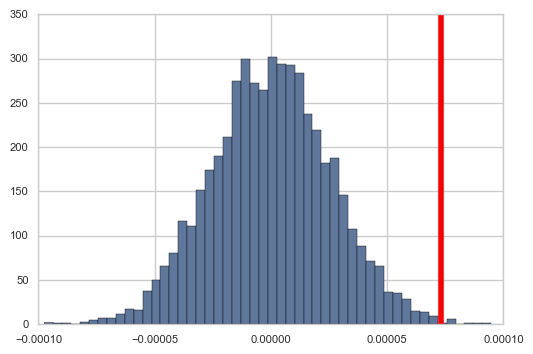

Bootstraping Type 1 error: 0.0020


In [26]:
bootstraping(backtest.stats.history.returns.dropna().values)

# Strategies analysis

In [27]:
strat_equities = pd.DataFrame()
trades['returns'] = trades.profit_R * risk

for key,strategy in manager.strategies.items():
    name = strategy.identifier
    equity = (1+trades.profit_R[trades.strategy == name]).cumprod()
    strat_equities = pd.concat([strat_equities,equity],axis=1)
strat_equities.fillna(method='pad',inplace=True)